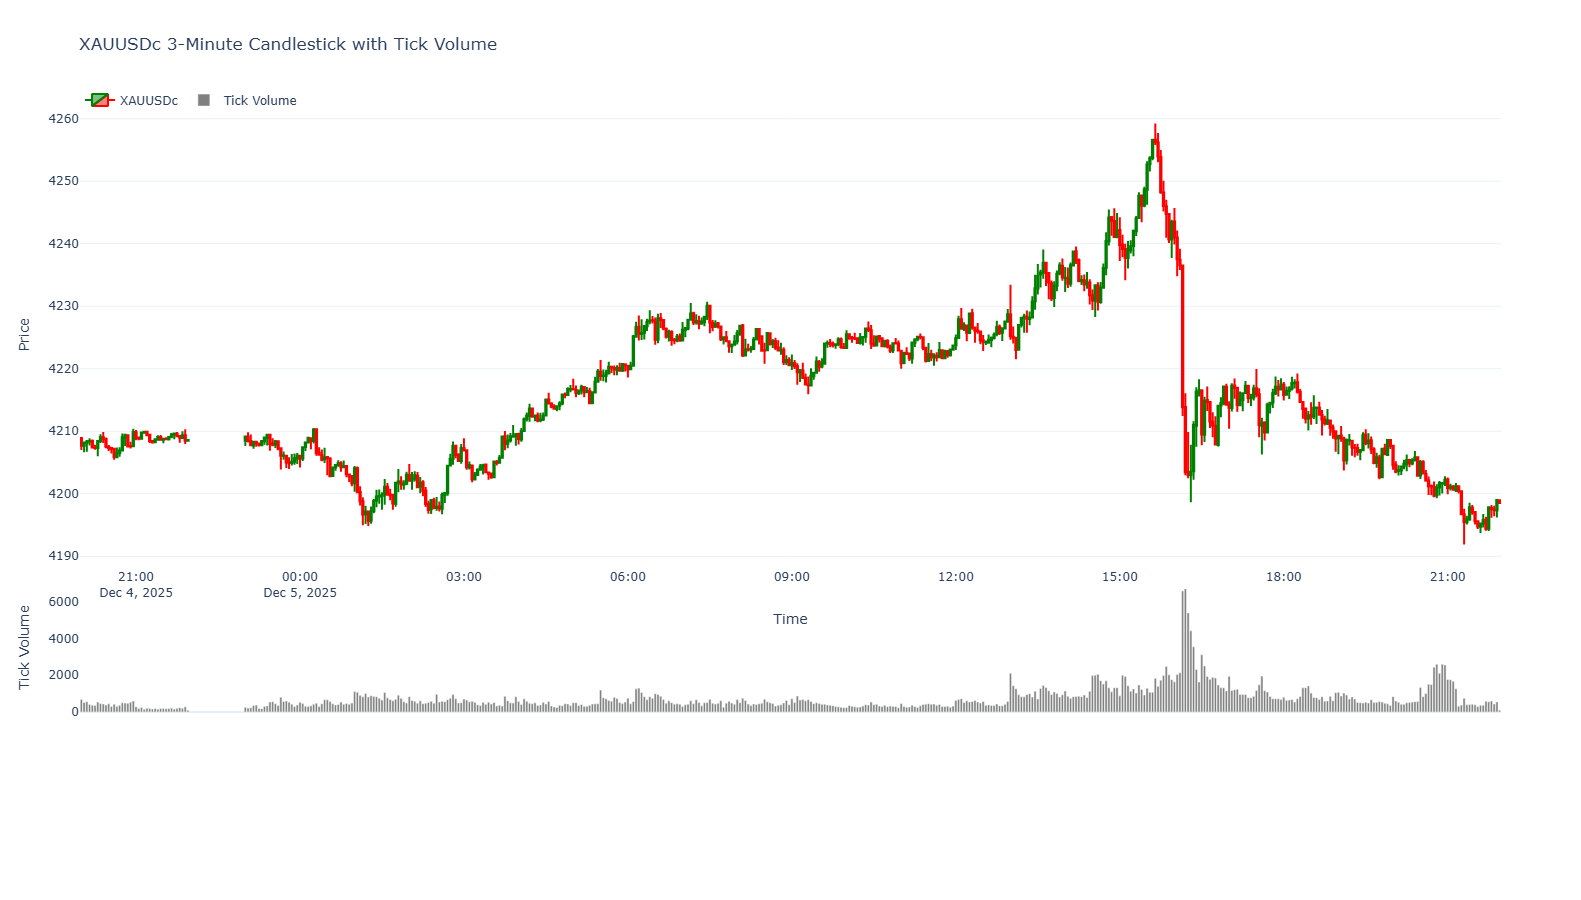

In [11]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Plot 3-pane chart (NO HIGHLIGHTS)
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Tick Volume',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


Tick volume bars are only used for this) This logic will be based on infinite number of lookback bars. Assign score at the corresponding bars. If the current bar is higher than the precious bars, then assigned a score based on how many lookbacks is it higher than. The core is infinite until the imaginary horizontal line (from the max value of the current bar to the left) intersect with another bar. And if the current bar is lesser than the previous bar then the score will be zero.

Tick volume is the only data used for scoring.

For each bar i:
If tick_volume[i] <= tick_volume[i-1], score = 0.
If tick_volume[i] > tick_volume[i-1], then:
Extend an imaginary horizontal line leftward from tick_volume[i].
Count how many consecutive previous bars are strictly lower than tick_volume[i]
until the first bar that is >= tick_volume[i].
The count becomes the score.
This creates an “infinite lookback until intersection” scoring.
The code adds a new column:
df['score']

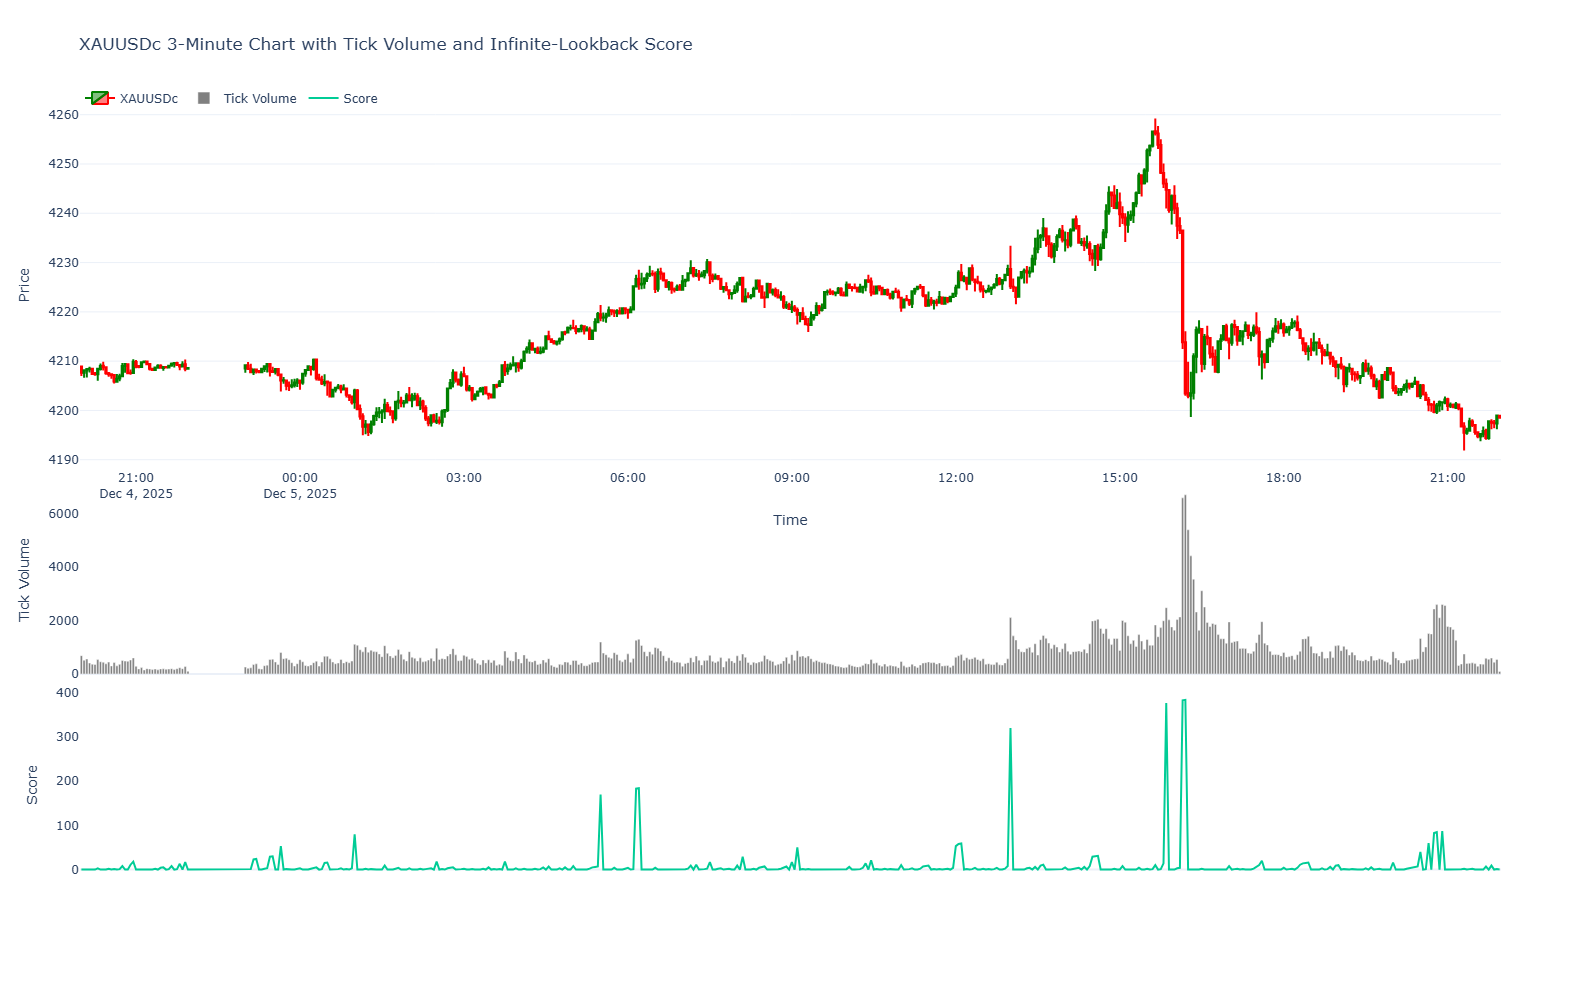

In [13]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score
# -------------------------
scores = [0]  # first bar has no previous bar, so score is zero

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        # Lower or equal → score = 0
        scores.append(0)
        continue

    # Otherwise (higher than previous bar)
    score = 0
    j = i - 1

    # Extend imaginary horizontal line to the left
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break  # intersection found → stop counting

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Plot 3-pane chart (NO HIGHLIGHTS)
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# (Optional) plot score line in lower pane — kept out unless you ask for it

fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Tick Volume',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    height=900
)

fig.show()


mark the close of the corresponding candlestick at where the momentum died (from high score to zero)

momentum-death markers on the price pane, placed exactly at the close of the candlestick where momentum collapses (transition from score > 0 to score = 0).

Definition used (per your instruction):
A momentum death occurs at bar i when:
score[i-1] > 0
score[i] == 0
At that bar, we mark df['close'][i] on the price chart.

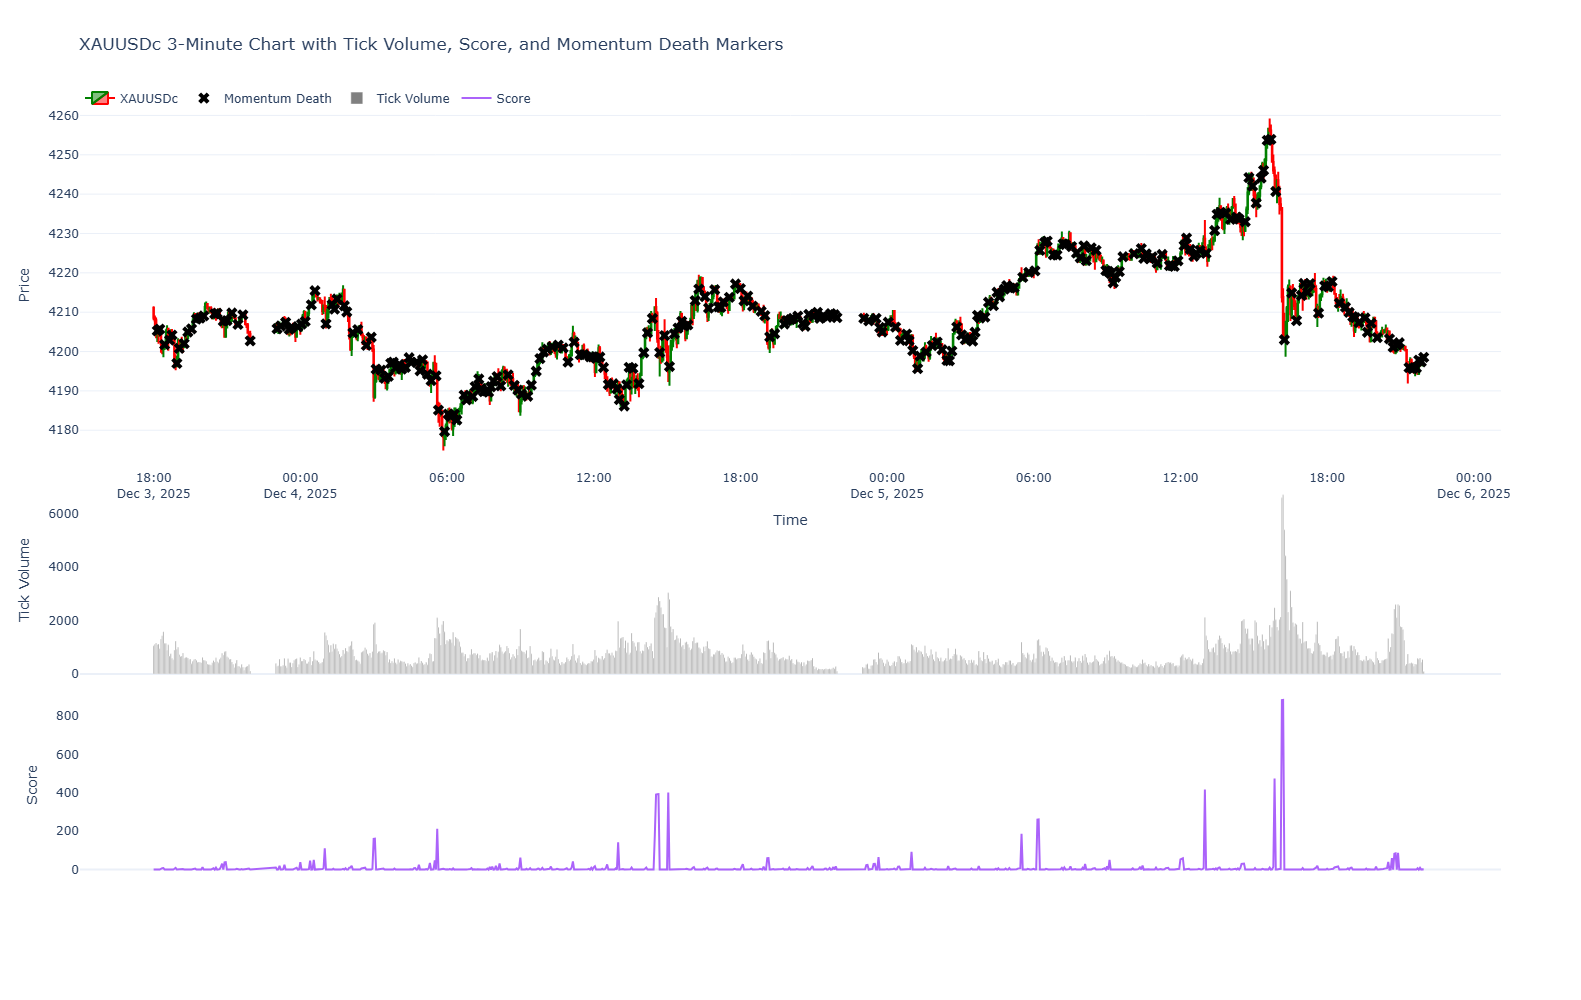

In [21]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 1000
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score
# -------------------------
scores = [0]

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1

    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points
# -------------------------
momentum_death_x = []
momentum_death_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

# -------------------------
# 7. Plot 3-pane chart
# -------------------------
fig = go.Figure()

# Price pane (top)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum death markers (on price pane)
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Tick Volume pane (middle)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Score pane (bottom)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart with Tick Volume, Score, and Momentum Death Markers',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.55, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.30, 0.53], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.05, 0.28], showgrid=False),

    height=1000,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


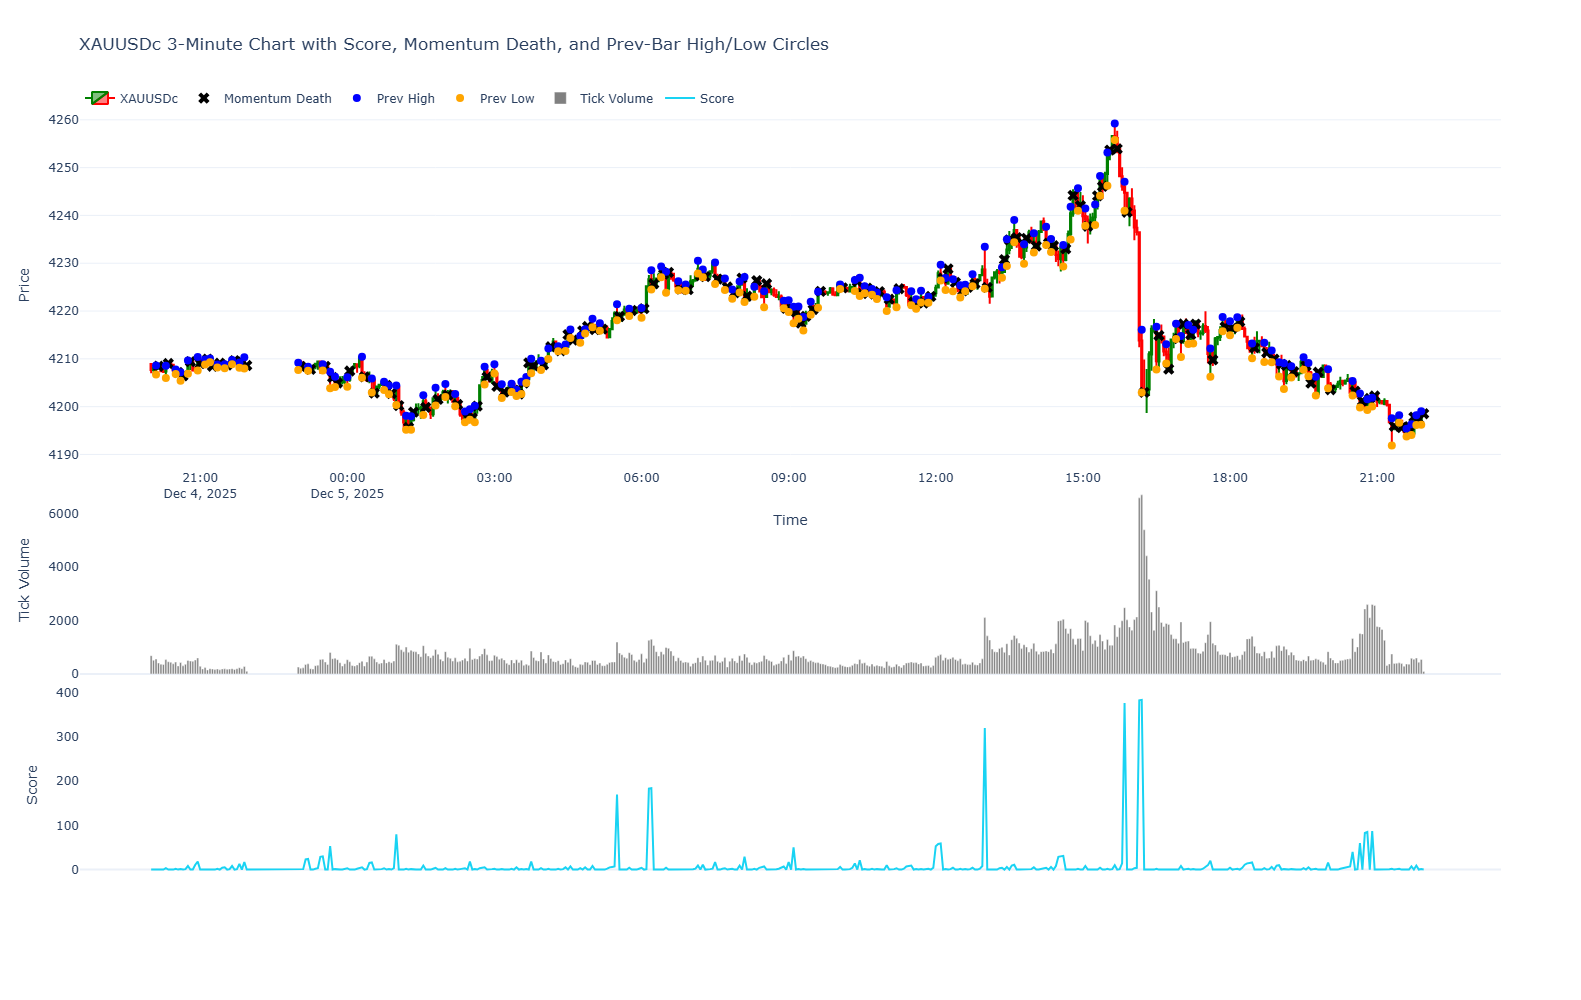

In [22]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score
# -------------------------
scores = [0]

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1

    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points
# -------------------------
momentum_death_x = []
momentum_death_y = []

# New arrays for previous-bar high/low circles
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:

        # close mark at momentum death
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        # previous bar (i - 1) high/low circles
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Plot 3-pane chart
# -------------------------
fig = go.Figure()

# Price pane (top)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death close markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Previous-bar HIGH circle
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))

# Previous-bar LOW circle
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Tick Volume pane (middle)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Score pane (bottom)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart with Score, Momentum Death, and Prev-Bar High/Low Circles',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.55, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.30, 0.53], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.05, 0.28], showgrid=False),

    height=1000,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


For this logic only use the candlesticks with ‘prev high’ and ‘prev low’ mark on them. Make another pane and label positive lookback score.The mechanics goes, if the ’prev high’ is higher than 50 lookback, then the score is 50, if higher than 30 then its score is 30, simple as that. The scoring is infinite, but the look back counting only stops at the intersection between prev high price to the left.

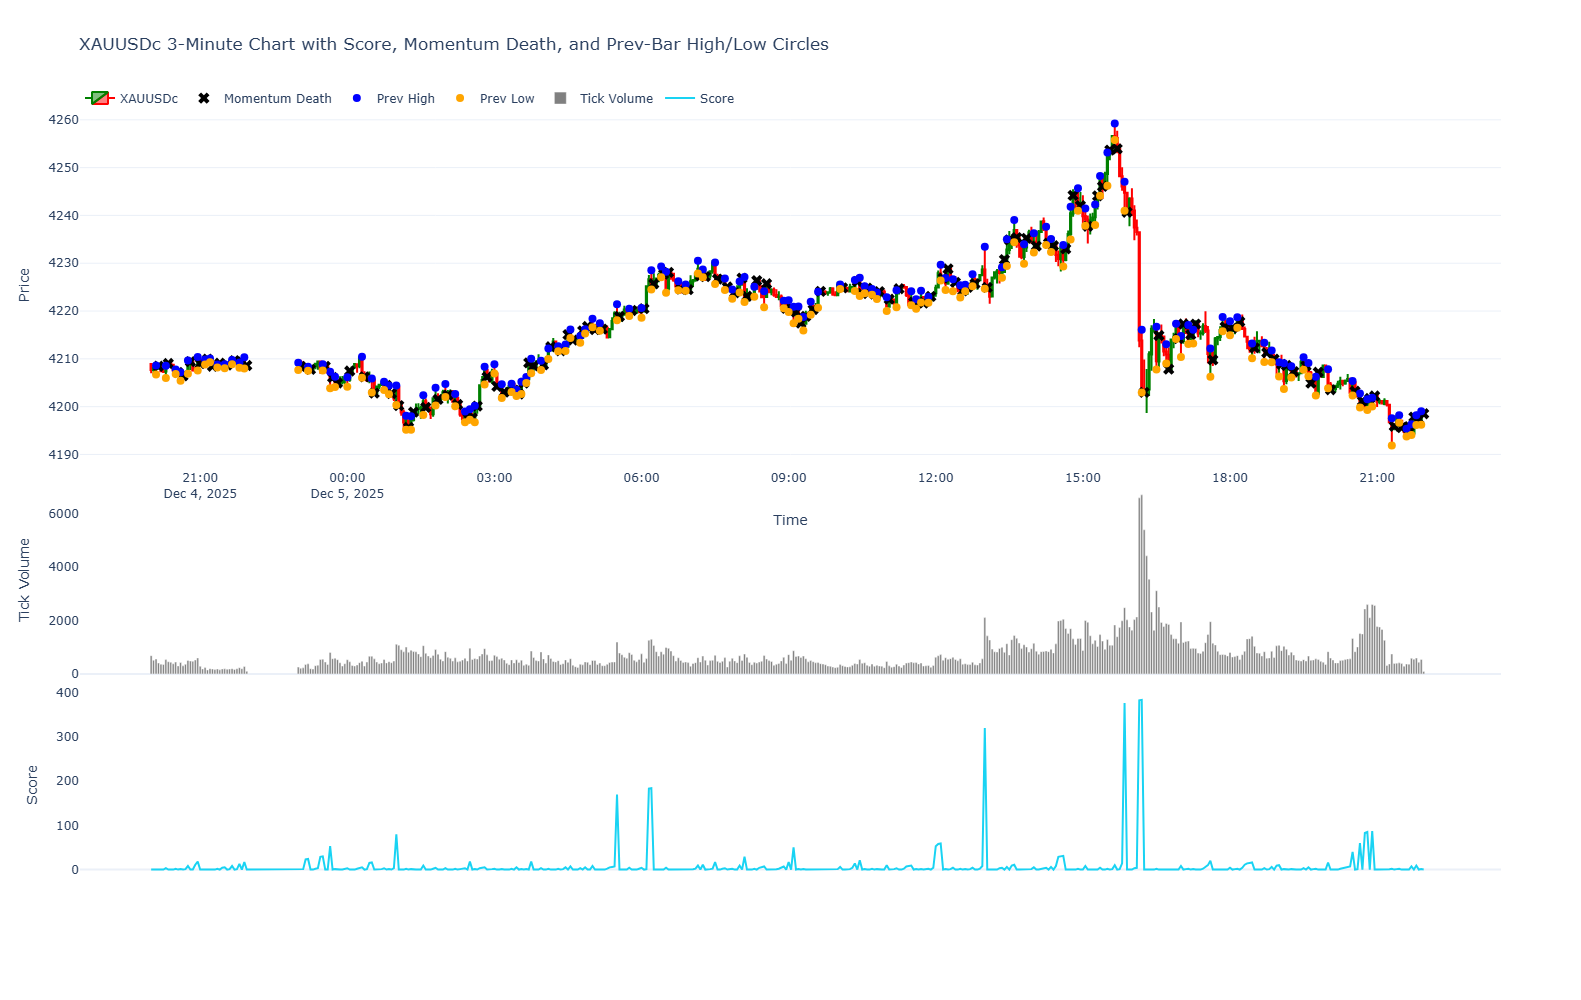

In [29]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score
# -------------------------
scores = [0]

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1

    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points
# -------------------------
momentum_death_x = []
momentum_death_y = []

# New arrays for previous-bar high/low circles
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:

        # close mark at momentum death
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        # previous bar (i - 1) high/low circles
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Plot 3-pane chart
# -------------------------
fig = go.Figure()

# Price pane (top)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death close markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Previous-bar HIGH circle
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))

# Previous-bar LOW circle
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Tick Volume pane (middle)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Score pane (bottom)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart with Score, Momentum Death, and Prev-Bar High/Low Circles',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.55, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.30, 0.53], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.05, 0.28], showgrid=False),

    height=1000,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


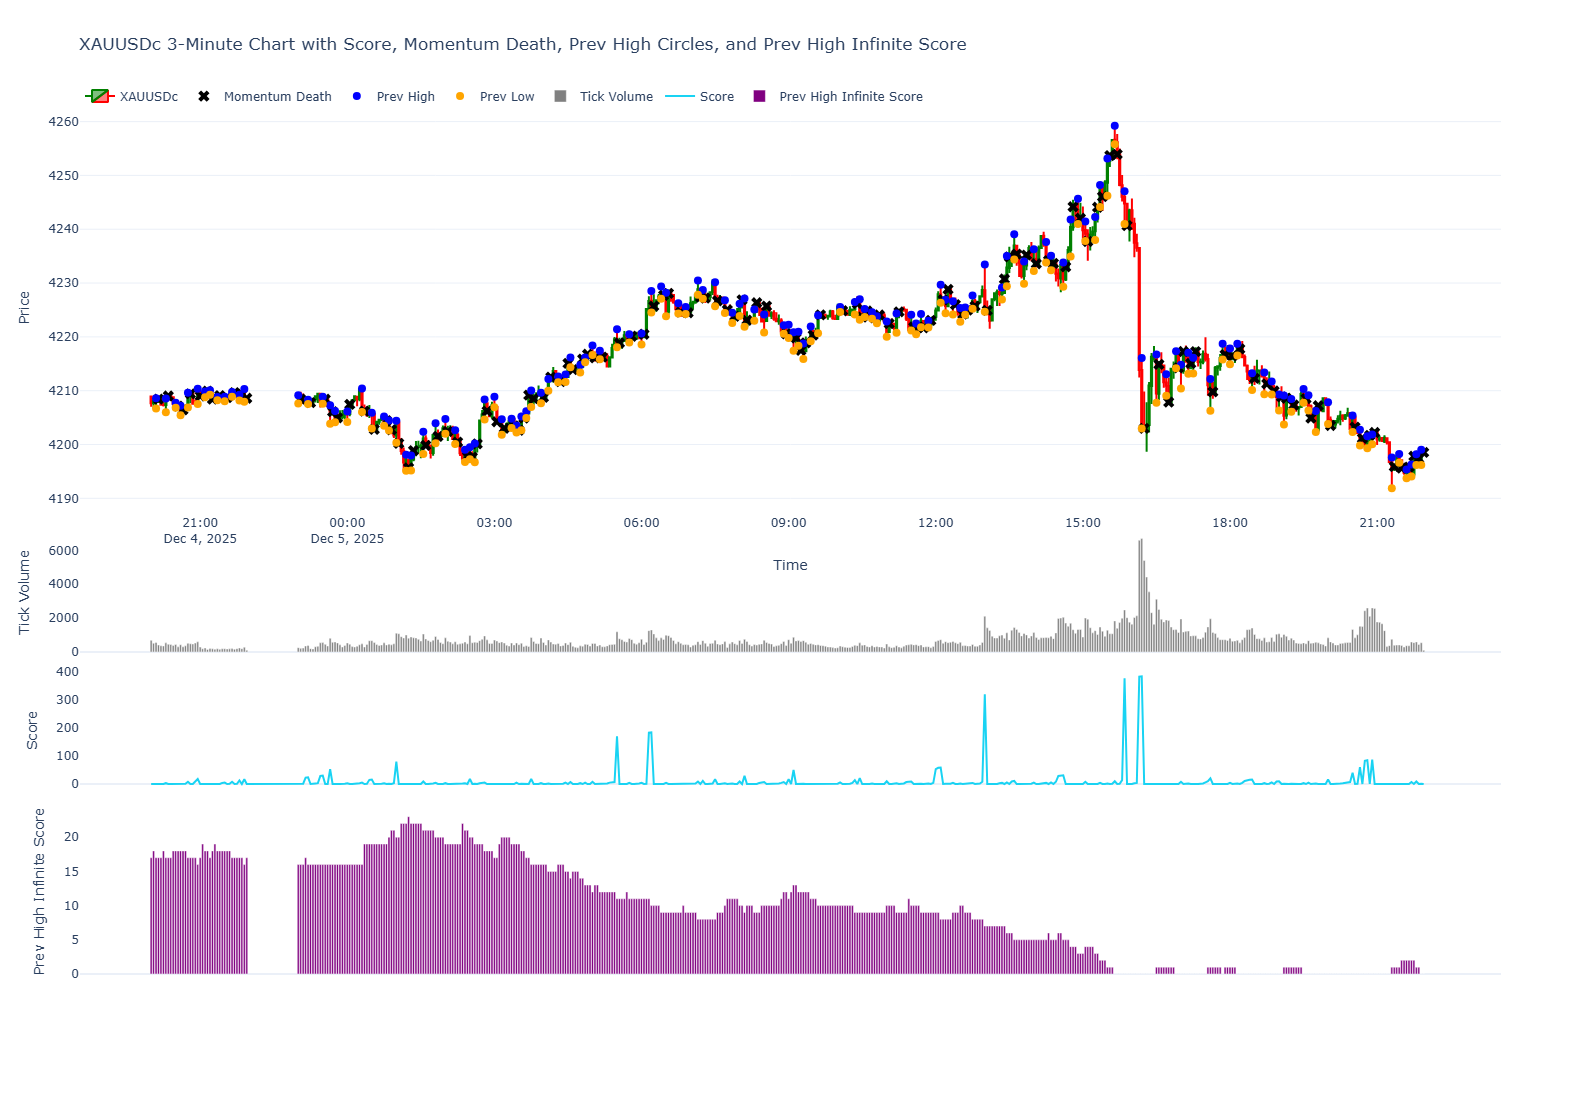

In [35]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (original momentum)
# -------------------------
scores = [0]

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1

    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points
# -------------------------
momentum_death_x = []
momentum_death_y = []

prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:

        # momentum-death close
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        # prev high/low circles
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left High Mark Score
# -------------------------
# initialize histogram array with zeros
prev_high_score = np.zeros(len(df))

# get indices of all bars with prev high marks
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    # scan left until horizontal line intersects previous candle (body/wick)
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break  # horizontal line intersects previous candle
        # if current high > previous high → assign score 1
        if current_high > df['high'].iloc[j]:
            prev_high_score[j] += 1
        j -= 1

df['prev_high_score'] = prev_high_score

# -------------------------
# 8. Plot 4-pane chart
# -------------------------
fig = go.Figure()

# Price pane (top)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death close markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Previous-bar HIGH circle
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))

# Previous-bar LOW circle
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Tick Volume pane (middle)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Score pane (bottom-middle)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev-high-infinite-score pane (bottom)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_score'],
    name='Prev High Infinite Score',
    marker_color='purple',
    yaxis='y4'
))

# Layout with 4 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart with Score, Momentum Death, Prev High Circles, and Prev High Infinite Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.55, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.40, 0.53], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.25, 0.38], showgrid=False),
    yaxis4=dict(title='Prev High Infinite Score', domain=[0.05, 0.23], showgrid=False),

    height=1100,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


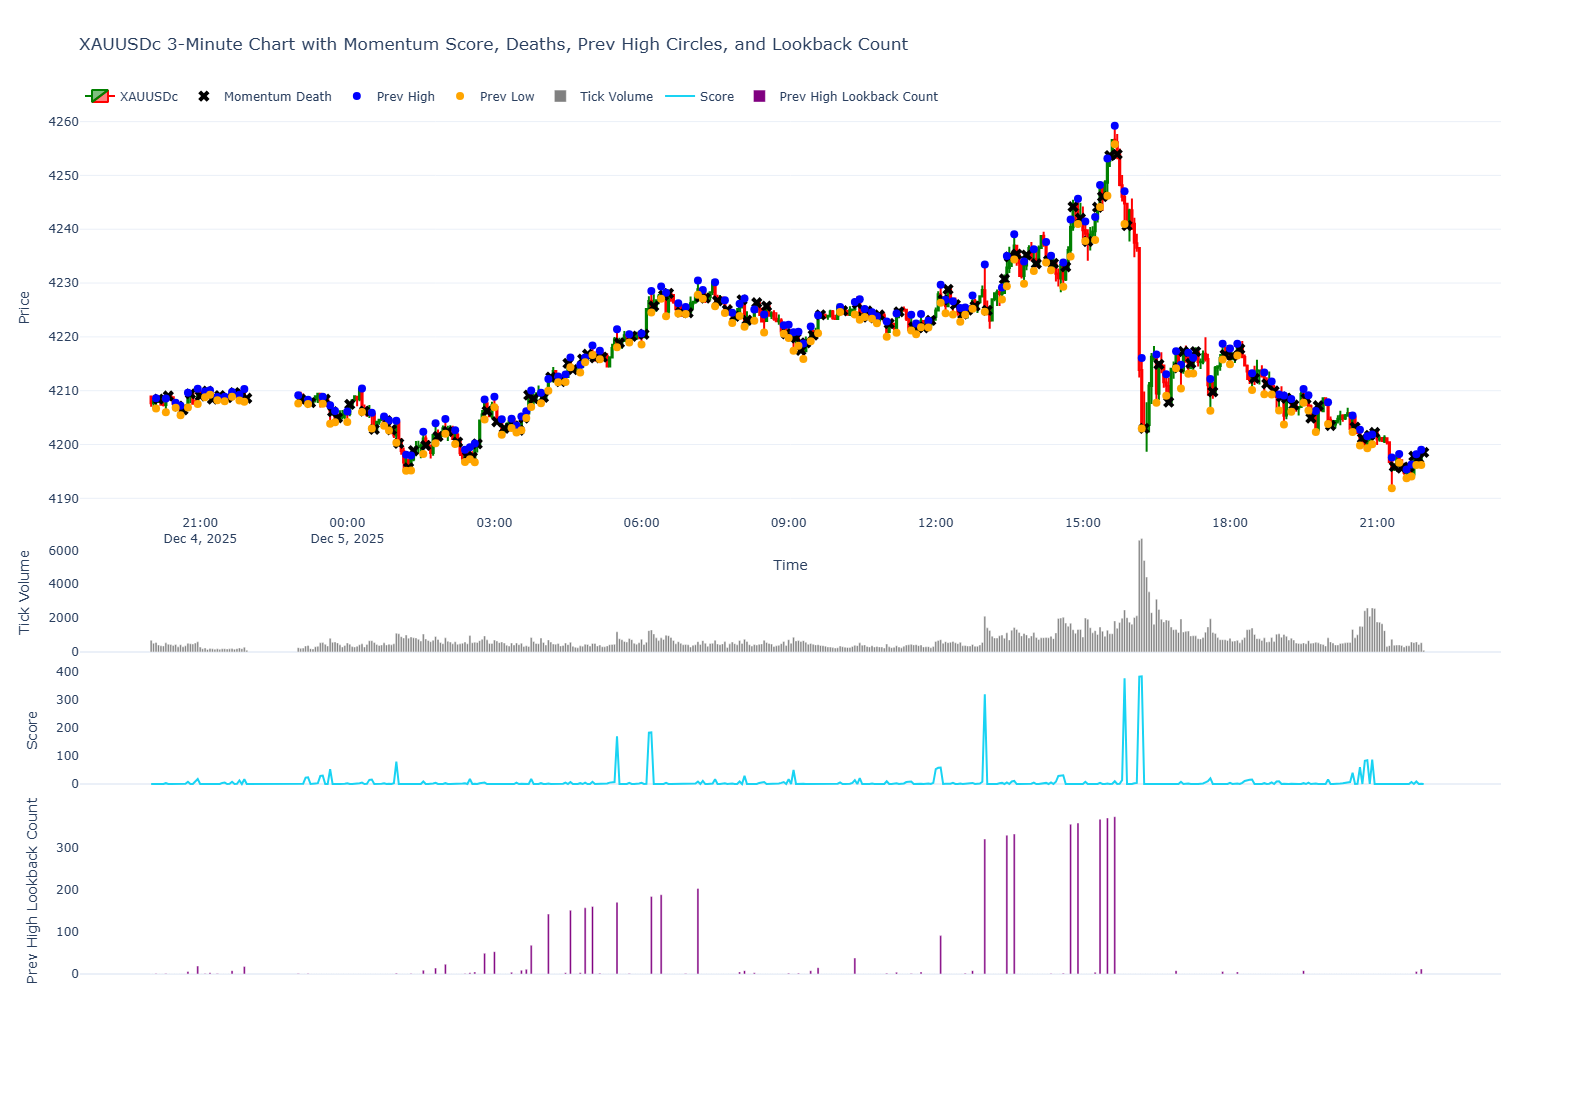

In [36]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (original momentum)
# -------------------------
scores = [0]

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1

    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points
# -------------------------
momentum_death_x = []
momentum_death_y = []

prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:

        # momentum-death close
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        # prev high/low circles
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))

# indices of all bars with prev high marks
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        # stop if horizontal line intersects previous candle body/wick
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count  # assign total lookback count

df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 8. Plot 4-pane chart
# -------------------------
fig = go.Figure()

# Price pane (top)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death close markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Previous-bar HIGH circle
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))

# Previous-bar LOW circle
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Tick Volume pane (middle)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Score pane (bottom-middle)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev-high-infinite-lookback-score pane (bottom)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Layout with 4 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart with Momentum Score, Deaths, Prev High Circles, and Lookback Count',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.55, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.40, 0.53], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.25, 0.38], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.05, 0.23], showgrid=False),

    height=1100,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


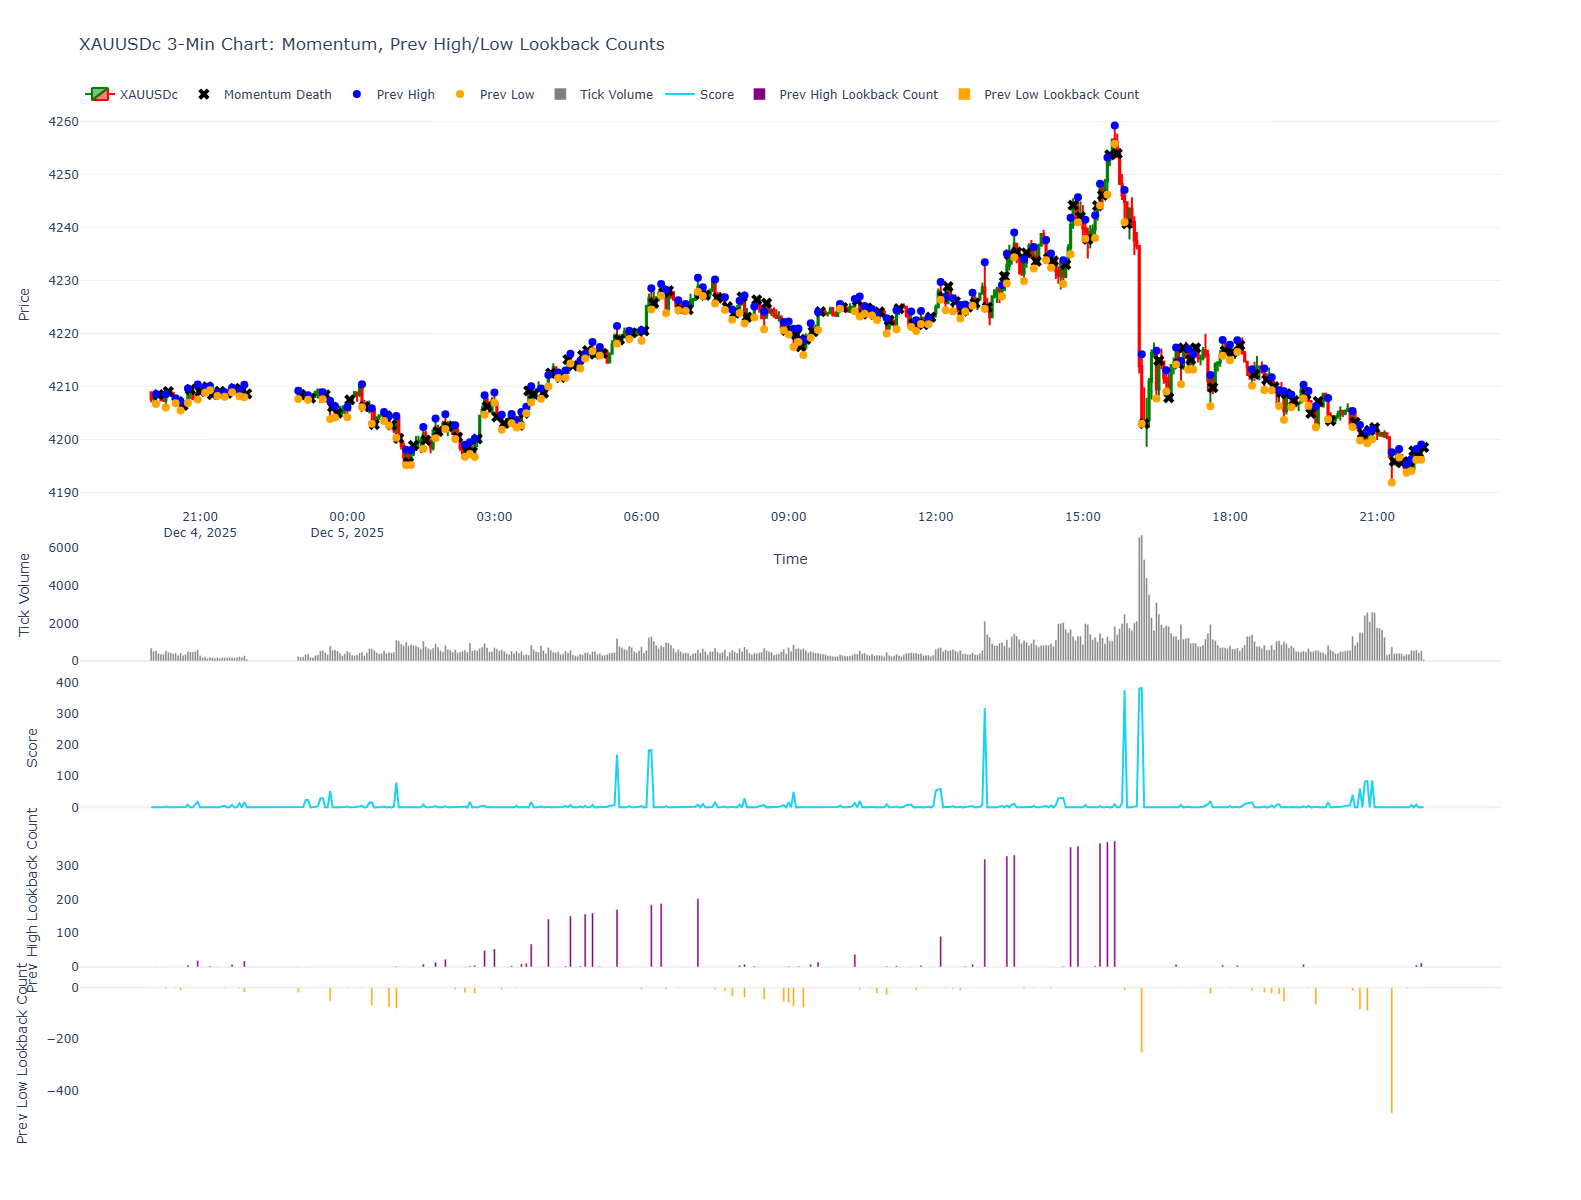

In [37]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]

for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1

    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break

    scores.append(score)

df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points and prev high/low marks
# -------------------------
momentum_death_x = []
momentum_death_y = []

prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:

        # momentum-death close
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        # prev high/low circles
        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        # stop if horizontal line intersects previous candle body/wick
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count

df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 8. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count  # negative

df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 9. Plot 5-pane chart
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))

fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane (negative)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Layout for 5 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Prev High/Low Lookback Counts',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price', domain=[0.60, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.45, 0.58], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.30, 0.43], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.15, 0.28], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.00, 0.13], showgrid=False),

    height=1200,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


mark the corresponding candlestick high if the 'Prev High Lookback Count' is 50 or higher. name it swing high. and mark the corresponding candlestick low if the 'Prev low Lookback Count' is -50 or lower. name it swing low

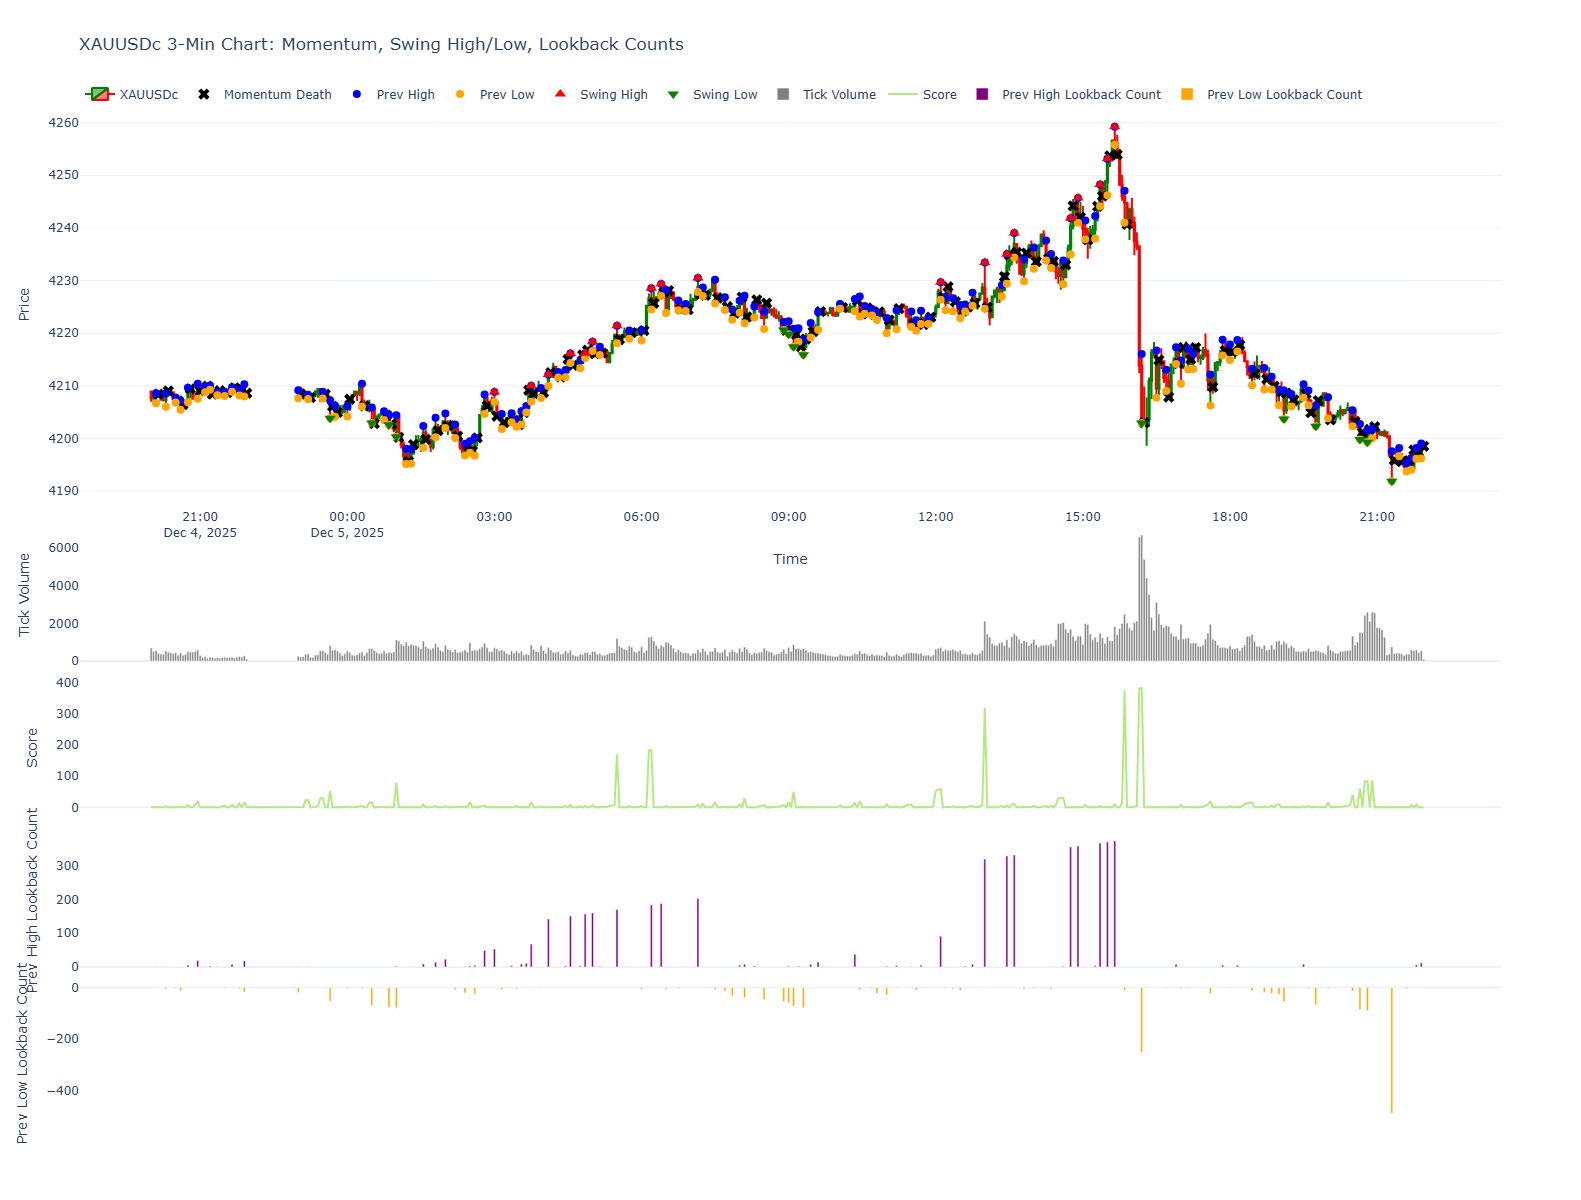

In [38]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)
df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points and prev high/low marks
# -------------------------
momentum_death_x = []
momentum_death_y = []
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count
df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 8. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count
df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 9. Detect Swing Highs and Swing Lows
# -------------------------
swing_high_x = []
swing_high_y = []
swing_low_x = []
swing_low_y = []

for i in range(len(df)):
    if df['prev_high_lookback_score'].iloc[i] >= 50:
        swing_high_x.append(df.index[i])
        swing_high_y.append(df['high'].iloc[i])
    if df['prev_low_lookback_score'].iloc[i] <= -50:
        swing_low_x.append(df.index[i])
        swing_low_y.append(df['low'].iloc[i])

# -------------------------
# 10. Plot 5-pane chart with Swing High/Low markers
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Swing High/Low markers
fig.add_trace(go.Scatter(
    x=swing_high_x,
    y=swing_high_y,
    mode='markers',
    name='Swing High',
    marker=dict(size=10, color='red', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=swing_low_x,
    y=swing_low_y,
    mode='markers',
    name='Swing Low',
    marker=dict(size=10, color='green', symbol='triangle-down'),
    yaxis='y'
))

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane (negative)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Layout for 5 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Swing High/Low, Lookback Counts',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.60, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.45, 0.58], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.30, 0.43], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.15, 0.28], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.00, 0.13], showgrid=False),
    height=1200,
    legend=dict(orientation='h', y=1.02, x=0)
)

fig.show()


from the swing points, scan the previous bars until it meets the opposite swing point, connect and use break line, use red break line if swing low to swing high, green break line if swing high to swing low, from current position to the left

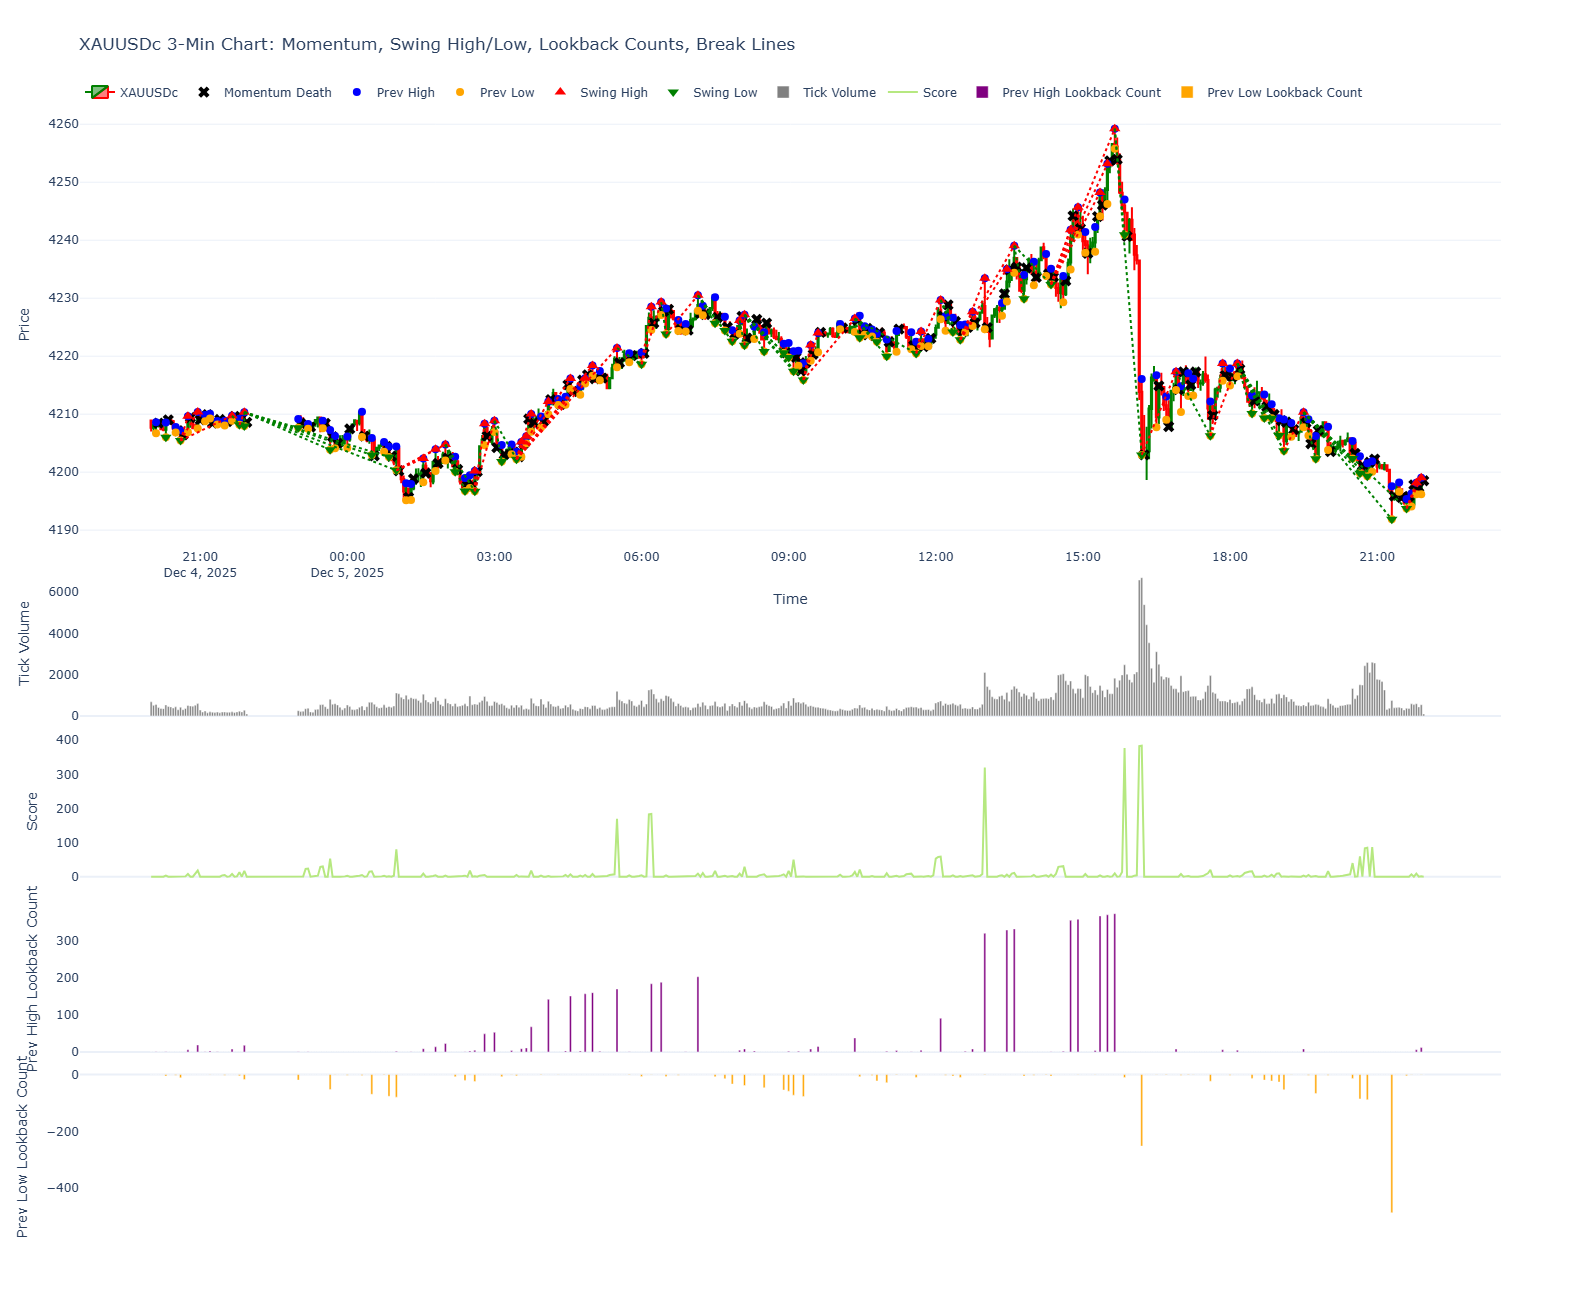

In [44]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)
df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points and prev high/low marks
# -------------------------
momentum_death_x = []
momentum_death_y = []
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count
df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 8. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count
df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 9. Detect Swing Highs and Swing Lows
# -------------------------
swing_high_x = []
swing_high_y = []
swing_low_x = []
swing_low_y = []

for i in range(len(df)):
    if df['prev_high_lookback_score'].iloc[i] >= 5:
        swing_high_x.append(df.index[i])
        swing_high_y.append(df['high'].iloc[i])
    if df['prev_low_lookback_score'].iloc[i] <= -5:
        swing_low_x.append(df.index[i])
        swing_low_y.append(df['low'].iloc[i])

# -------------------------
# 10. Prepare Break Lines Between Swing Points
# -------------------------
break_lines = []

# Combine swing highs and lows into a DataFrame
swings = pd.DataFrame({
    'time': swing_high_x + swing_low_x,
    'price': swing_high_y + swing_low_y,
    'type': ['high'] * len(swing_high_x) + ['low'] * len(swing_low_x)
})
swings = swings.sort_values('time').reset_index(drop=True)

# Connect each swing to nearest previous opposite swing
for i in range(1, len(swings)):
    current = swings.iloc[i]
    for j in range(i - 1, -1, -1):
        prev = swings.iloc[j]
        if prev['type'] != current['type']:
            line_color = 'red' if prev['type'] == 'low' and current['type'] == 'high' else 'green'
            break_lines.append(dict(
                type="line",
                x0=prev['time'],
                y0=prev['price'],
                x1=current['time'],
                y1=current['price'],
                line=dict(color=line_color, width=2, dash='dot'),
                xref="x",
                yref="y",
                layer="above"
            ))
            break

# -------------------------
# 11. Plot 5-pane chart with Swing High/Low and Break Lines
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Swing High/Low markers
fig.add_trace(go.Scatter(
    x=swing_high_x,
    y=swing_high_y,
    mode='markers',
    name='Swing High',
    marker=dict(size=10, color='red', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=swing_low_x,
    y=swing_low_y,
    mode='markers',
    name='Swing Low',
    marker=dict(size=10, color='green', symbol='triangle-down'),
    yaxis='y'
))

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane (negative)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Layout with 5 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Swing High/Low, Lookback Counts, Break Lines',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.60, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.45, 0.58], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.30, 0.43], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.15, 0.28], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.00, 0.13], showgrid=False),
    height=1300,
    legend=dict(orientation='h', y=1.02, x=0),
    shapes=break_lines
)

fig.show()
